In [43]:
from matplotlib import pyplot as plt
import os
import os.path as osp
import re
import numpy as np
import copy
import scipy.signal as signal

plt.rcParams['figure.figsize']=(12,8)

In [44]:
l='Epoch 0003 [Train seq (cond on sampled tp)] | Loss 3880661.165175 | MAPE 0.227065 | RMSE 257.806133 | Likelihood -3880655.378434 | KL fp 5.7867 | FP STD 0.8212 | ->nfe   20.00 | <-nfe  491.00'
if re.search('nfe',l):
    print(11)

11


In [82]:
def get_logs(log_file, epochs = 100):
    with open(osp.join('logs',log_file),'r') as f:
        logs = f.read()
    logs = logs.split('\n')
    com_line = logs[1]
    logs = logs[5:]
    if 'Best Val!' in logs:
        logs.remove('Best Val!')
    # print(len(logs))
    train_loss = np.zeros(epochs)
    train_MAPE = np.zeros(epochs)
    test_MAPE = np.zeros(epochs)
    val_MAPE = np.zeros(epochs)
    train_RMSE = np.zeros(epochs)
    test_RMSE = np.zeros(epochs)
    val_RMSE = np.zeros(epochs)
    for_nfe = np.zeros(epochs)
    back_nfe = np.zeros(epochs)
    trains = []
    for iter_log in logs:
        if re.match('Epoch [0-9]* \[Test seq \(cond on sampled tp\)\] \| MAPE', iter_log):
            test_MAPE[int(iter_log[6:10])-1] = float(iter_log[50:58])
            test_RMSE[int(iter_log[6:10])-1] = float(iter_log[66:-2])
        elif re.match('Epoch [0-9]* \[Val seq \(cond on sampled tp\)\] \|  MAPE', iter_log):
            val_MAPE[int(iter_log[6:10])-1] = float(iter_log[50:58])
            val_RMSE[int(iter_log[6:10])-1] = float(iter_log[66:-2])
            trains.append(iter_log)
        elif re.match('Epoch [0-9]* \[Train seq \(cond on sampled tp\)\] \| Loss', iter_log):
            train_loss[int(iter_log[6:10])-1] = float(iter_log[51:65])
            train_MAPE[int(iter_log[6:10])-1] = float(iter_log[73:81])
            train_RMSE[int(iter_log[6:10])-1] = float(iter_log[89:99])
            if re.search('nfe',iter_log):
                for_nfe[int(iter_log[6:10])-1] = float(re.search('->nfe *[0-9]*\.[0-9]* \|',iter_log).group()[5:-1])
                back_nfe[int(iter_log[6:10])-1] = float(re.search('<-nfe *[0-9]*\.[0-9]*',iter_log).group()[5:])

                
            # trains.append(iter_log)
    return com_line, train_loss,train_MAPE ,test_MAPE,val_MAPE, train_RMSE, test_RMSE,val_RMSE, for_nfe, back_nfe

        
def get_order(val_MAPEs):
    tmp = val_MAPEs.copy()
    tmp.sort()
    return [tmp.index(i) for i in val_MAPEs]

In [83]:
# 根据不同的实验筛选log_files
def log_filter(dir, situation):
    if situation == "hbargs": #search_hbargs
        return dir[:29] == 'run_Dec_Con_21_Pre_14_07-07_0'
    elif situation == 'very_raw':
        return dir[22:27] in ['88950','77873','52532']
    elif situation == 'raw':
        return dir[:30] == 'run_Dec_Con_21_Pre_14_07-07_23'
    elif situation == "no_Zt_hbargs":
        return dir[:29] == 'run_Dec_Con_21_Pre_14_07-08_0'
    elif situation == "test10":
        return dir[:30] == 'run_Dec_Con_21_Pre_14_07-10_20'
    elif situation == "nfe_raw":
        return dir[:29] == 'run_Dec_Con_21_Pre_14_07-12_1' and int(dir[29]) >= 2
    elif situation == "nfe_hvb":
        return dir[:28] == 'run_Dec_Con_21_Pre_14_07-12_' and 5+55/60<=int(dir[28:30])+int(dir[31:33])/60 <= 11.5
    else:
        raise NotImplementedError

def get_log_files(situation):
    '''
    get sorted log files
    '''
    log_files = [] 
    for dir in os.listdir('logs'):
        if (log_filter(dir, situation)):
            log_files.append(dir)
    log_files.sort()
    return log_files


In [116]:
class Analyse:
    def __init__(self,situation, last = 5):
        self.log_files = get_log_files(situation)
        self.avg_test_MAPE,self.avg_val_MAPE,self.command_lines,self.train_loss,self.train_MAPE ,self.test_MAPE,self.val_MAPE, self.train_RMSE, self.test_RMSE,self.val_RMSE,self.for_nfes, self.back_nfes = [[] for _ in range(12)]
        labels = range(len(self.log_files))
        self.mask_lbl = [] # 用于筛出没训到最后epoch的
        for file in [self.log_files[i] for i in labels]:
            output = get_logs(file)
            for j,list_ in enumerate([self.command_lines,self.train_loss,self.train_MAPE ,self.test_MAPE,self.val_MAPE, self.train_RMSE, self.test_RMSE,self.val_RMSE,self.for_nfes, self.back_nfes]):
                list_.append(output[j])

            self.avg_test_MAPE.append(self.test_MAPE[-1][-last:].mean())
            self.avg_val_MAPE.append(self.val_MAPE[-1][-last:].mean())
            if output[1][-1] == 0.0:
                self.mask_lbl.append(self.log_files.index(file))
        
    def plot(self,mode,index=None,smooth=False): # consider train, test, val
        if index is None:
            index = range(len(self.log_files))
        draw =  eval('self.%s_MAPE' % mode).copy()
        for i in index:
            if smooth:
                draw[i] = signal.savgol_filter(draw[i],11,3)
            plt.plot(draw[i])
        plt.legend(index)
        
    def best_in_val(self, count=5): # count:选前几好的结果
        tmp = self.avg_val_MAPE.copy()
        for i in self.mask_lbl:
            tmp[i] = np.Inf
        tmp.sort()
        return [self.avg_val_MAPE.index(i) for i in tmp[:count]]
    
    def ana_nfe(self,mode='avg'):
        'output: avg/max/min for_nfe, back_nfe'
        if mode=='avg':
            return np.array(self.for_nfes).mean(),np.array(self.back_nfes).mean()
        elif mode=='min':
            return min([i.mean() for i in self.for_nfes]),min([i.mean() for i in self.back_nfes])
        elif mode=='max':
            return max([i.mean() for i in self.for_nfes]),max([i.mean() for i in self.back_nfes])



[15, 3, 16, 10, 7]
avg: [0.0491888, 0.05721540000000001, 0.0531116, 0.050105, 0.05358500000000001]
min: [0.042539, 0.048521, 0.045983, 0.040822, 0.040113]


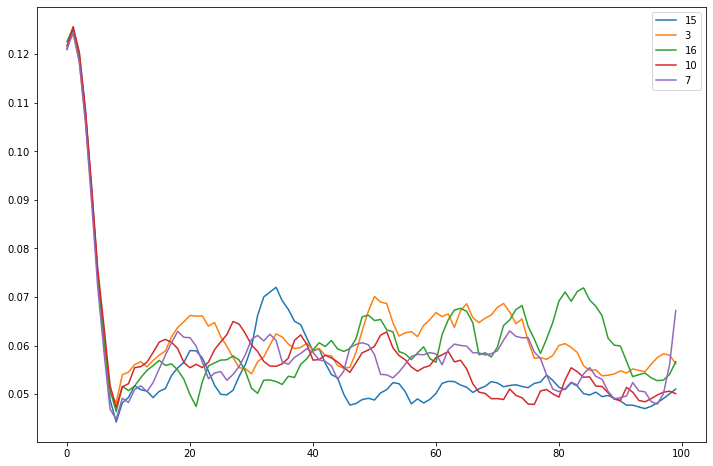

In [7]:
# 分析只调整hbargs的数据：
ana_hb = Analyse("hbargs")
best_id = ana_hb.best_in_val()
print(best_id)
print("avg:",[ana_hb.avg_test_MAPE[i] for i in best_id])
print("min:",[ana_hb.test_MAPE[i].min() for i in best_id])
ana_hb.plot('test', index = best_id,smooth=True)
# 只看test min，15， 10， 7的参数最好

In [8]:
ana_hb.log_files[12]  #--gamma_guess 3.0 --corr -100
ana_hb.log_files[10]  #--gamma_guess 0.0 --corr 5
ana_hb.log_files[15]  #--gamma_guess 3.0 --corr 1

'run_Dec_Con_21_Pre_14_07-07_03:21.log'

[0, 1, 2]
avg: [0.0481074, 0.04573699999999999, 0.0470248]
min: [0.044554, 0.040789, 0.037723]


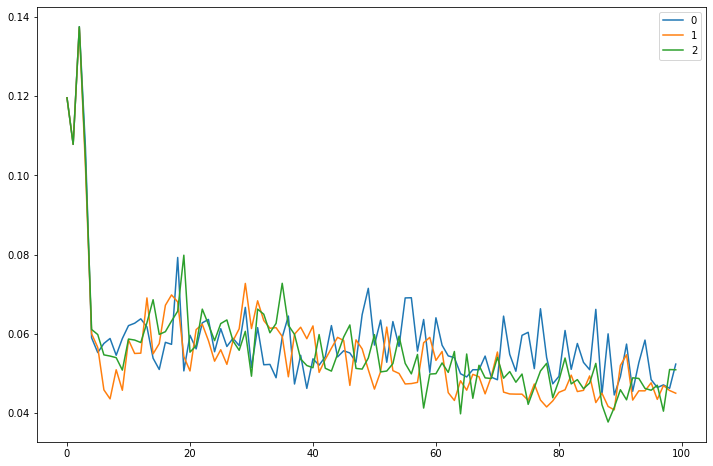

In [9]:
ana_raw = Analyse("very_raw")
best_id = ana_raw.best_in_val()
print(best_id)
print("avg:",[ana_raw.avg_test_MAPE[i] for i in best_id])
print("min:",[ana_raw.test_MAPE[i].min() for i in best_id])
ana_raw.plot('test', index = best_id,smooth=False)

[16, 2, 11, 14, 5]
avg: [0.0460178, 0.0469276, 0.0480694, 0.0637462, 0.0536018]
min: [0.039672, 0.041882, 0.04183, 0.047925, 0.042323]


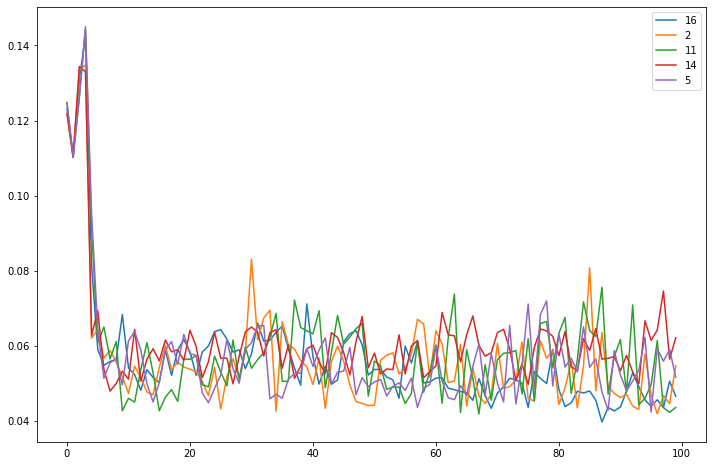

In [10]:
ana = Analyse("no_Zt_hbargs")
best_id = ana.best_in_val()
print(best_id)
print("avg:",[ana.avg_test_MAPE[i] for i in best_id])
print("min:",[ana.test_MAPE[i].min() for i in best_id])
ana.plot('test', index = best_id,smooth=False)

run_models_covid.py --heavyBall --gamma_guess 0.0 --corr 5
run_models_covid.py --heavyBall --gamma_guess 0.0 --corr 5
0.042948 0.040822


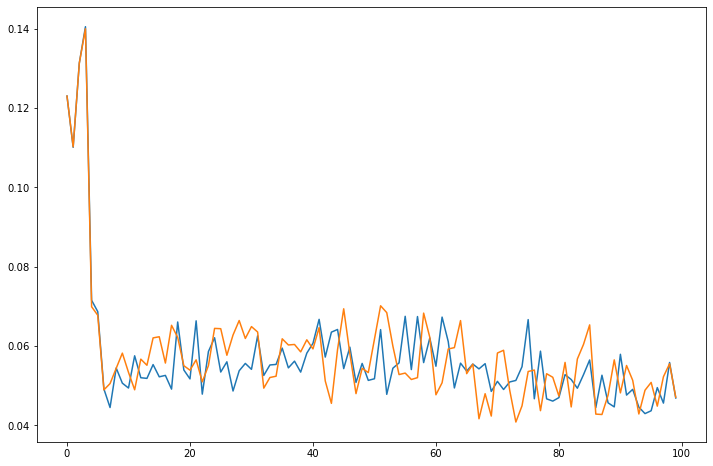

In [19]:
ana = Analyse("test10")
plt.plot(ana.test_MAPE[0])
plt.plot(ana_hb.test_MAPE[10])
print(ana.command_lines[0],ana_hb.command_lines[10],sep='\n')
print(ana.test_MAPE[0].min(),ana_hb.test_MAPE[10].min())
# FIXME:之后测试选取这组参数作为base_line:  --gamma_guess 0.0 --corr 5

平均nfe：
hvb: (142.805, 712.421) 
raw: (90.7415, 1142.021)
最大nfe：
hvb: (149.87, 880.8875) 
raw: (109.1525, 1680.2825)


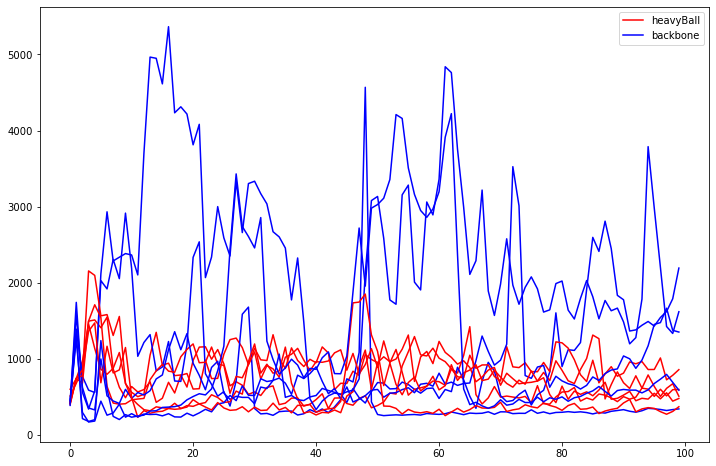

In [118]:
# 可视化NFE：
ana_hvb = Analyse('nfe_hvb')
ana_raw = Analyse('nfe_raw')
print('平均nfe：\nhvb:',ana_hvb.ana_nfe(),'\nraw:',ana_raw.ana_nfe())
print('最大nfe：\nhvb:',ana_hvb.ana_nfe('max'),'\nraw:',ana_raw.ana_nfe('max'))
for for_h,for_r,back_h,back_r in zip(ana_hvb.for_nfes,ana_raw.for_nfes,ana_hvb.back_nfes,ana_raw.back_nfes):
    # plt.plot(for_h,'r')
    # plt.plot(for_r,'b')
    plt.plot(back_h,'r')
    plt.plot(back_r,'b')
plt.legend(['heavyBall','backbone'])

In [123]:
print('hvb',[min(MAPE) for MAPE in ana_hvb.test_MAPE])
print('raw',[min(MAPE) for MAPE in ana_raw.test_MAPE])

hvb [0.04217, 0.041489, 0.038844, 0.043189, 0.043565]
raw [0.039911, 0.043529, 0.043113, 0.042224, 0.041992]


# 之前的代码。。。。

In [ ]:
nomomen_log1 = 'run_Dec_Con_21_Pre_14_88950.log'
nomomen_log2 = 'run_Dec_Con_21_Pre_14_77873.log'
nomomen_log3 = 'run_Dec_Con_21_Pre_14_52532.log'

momen_log1 = 'run_Dec_Con_21_Pre_14_06-19_23:19.log'
momen_log2 = 'run_Dec_Con_21_Pre_14_06-19_23:42.log'

graform_log1 = 'run_Dec_Con_21_Pre_14_06-30_23:20.log'

In [100]:
n1_train_loss,n1_train_MAPE ,n1_test_MAPE,n1_val_MAPE, n1_train_RMSE, n1_test_RMSE,n1_val_RMSE = get_logs(nomomen_log1)
n2_train_loss,n2_train_MAPE ,n2_test_MAPE,n2_val_MAPE, n2_train_RMSE, n2_test_RMSE,n2_val_RMSE = get_logs(nomomen_log2)
n3_train_loss,n3_train_MAPE ,n3_test_MAPE,n3_val_MAPE, n3_train_RMSE, n3_test_RMSE,n3_val_RMSE = get_logs(nomomen_log3)

m1_train_loss,m1_train_MAPE ,m1_test_MAPE,m1_val_MAPE, m1_train_RMSE, m1_test_RMSE,m1_val_RMSE = get_logs(momen_log1,epochs=200)
m2_train_loss,m2_train_MAPE ,m2_test_MAPE,m2_val_MAPE, m2_train_RMSE, m2_test_RMSE,m2_val_RMSE = get_logs(momen_log2,epochs=200)

# g1_train_loss,g1_train_MAPE ,g1_test_MAPE,g1_val_MAPE, g1_train_RMSE, g1_test_RMSE,g1_val_RMSE = get_logs(graform_log1)


0.037723 0.040789 0.044554


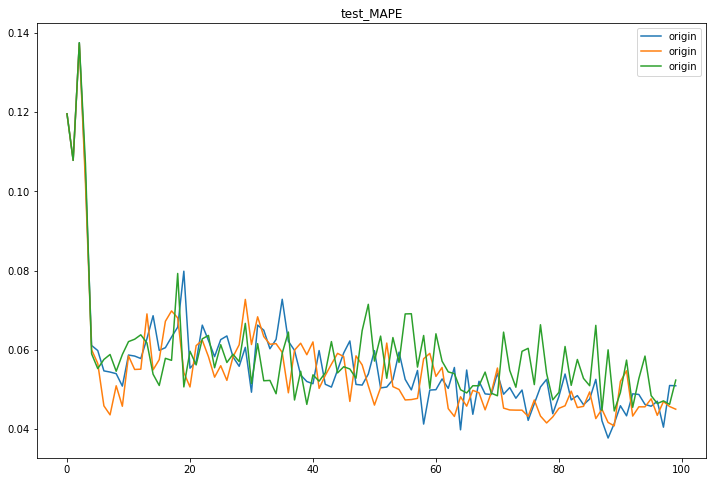

In [119]:
plt.plot(n1_test_MAPE[:100])
plt.plot(n2_test_MAPE[:100])
plt.plot(n3_test_MAPE[:100])

# plt.plot(m1_test_MAPE)
# plt.plot(m1_test_MAPE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('test_MAPE')
plt.savefig('./figs/test_MAPE.png')
print(n1_test_MAPE.min(),n2_test_MAPE.min(),n3_test_MAPE.min())
# print(m1_test_MAPE.min(),m2_test_MAPE.min())


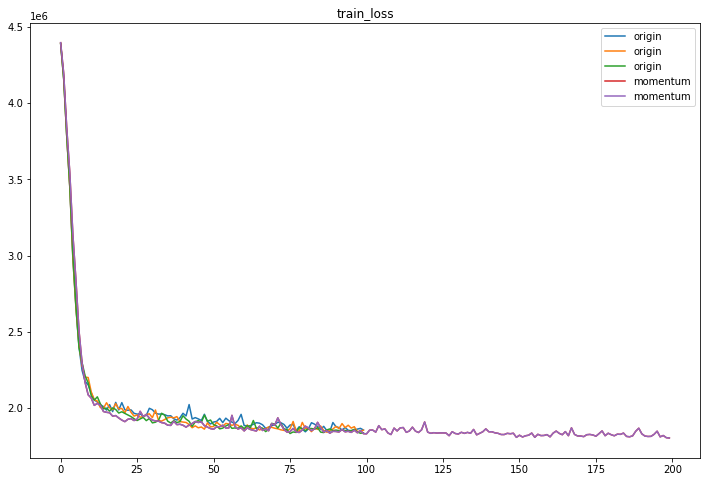

In [101]:
plt.plot(n1_train_loss[:100])
plt.plot(n2_train_loss[:100])
plt.plot(n3_train_loss[:100])

plt.plot(m1_train_loss)
plt.plot(m1_train_loss)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('train_loss')
plt.savefig('./figs/train_loss.png')

NameError: name 'g1_train_MAPE' is not defined

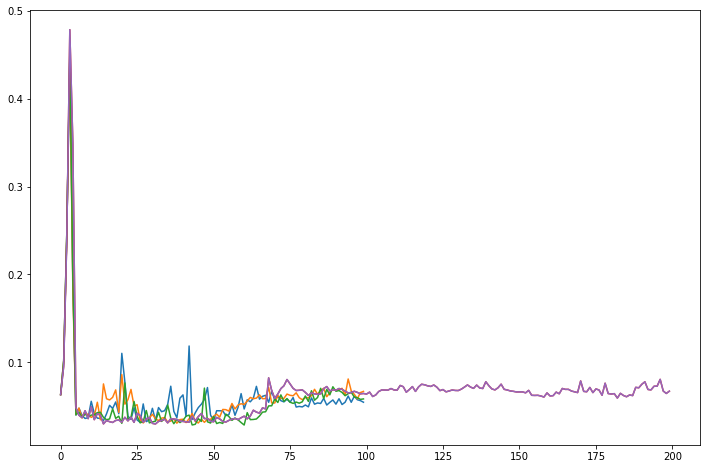

In [102]:
plt.plot(n1_train_MAPE[:100])
plt.plot(n2_train_MAPE[:100])
plt.plot(n3_train_MAPE[:100])

plt.plot(m1_train_MAPE)
plt.plot(m1_train_MAPE)

plt.plot(g1_train_MAPE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('train_MAPE')
plt.savefig('./figs/train_MAPE.png')



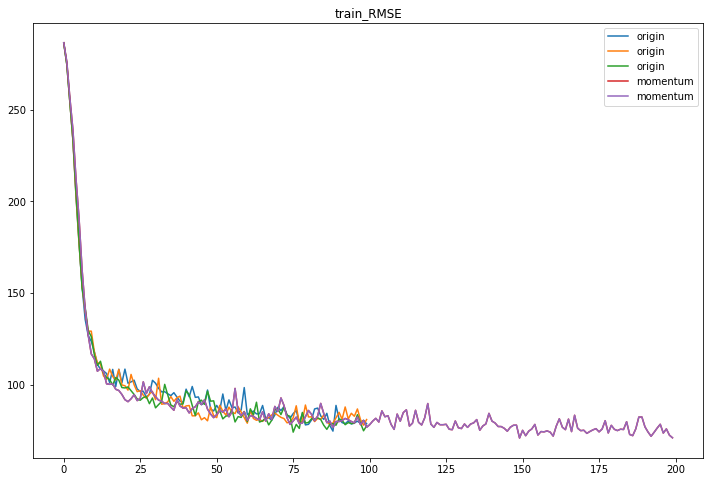

In [103]:
plt.plot(n1_train_RMSE[:100])
plt.plot(n2_train_RMSE[:100])
plt.plot(n3_train_RMSE[:100])

plt.plot(m1_train_RMSE)
plt.plot(m1_train_RMSE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('train_RMSE')
plt.savefig('./figs/train_RMSE.png')



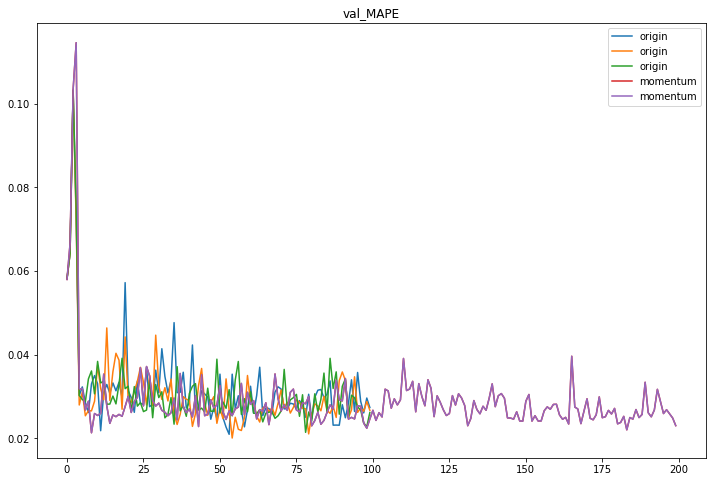

In [104]:
plt.plot(n1_val_MAPE[:100])
plt.plot(n2_val_MAPE[:100])
plt.plot(n3_val_MAPE[:100])

plt.plot(m1_val_MAPE)
plt.plot(m1_val_MAPE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('val_MAPE')
plt.savefig('./figs/val_MAPE.png')

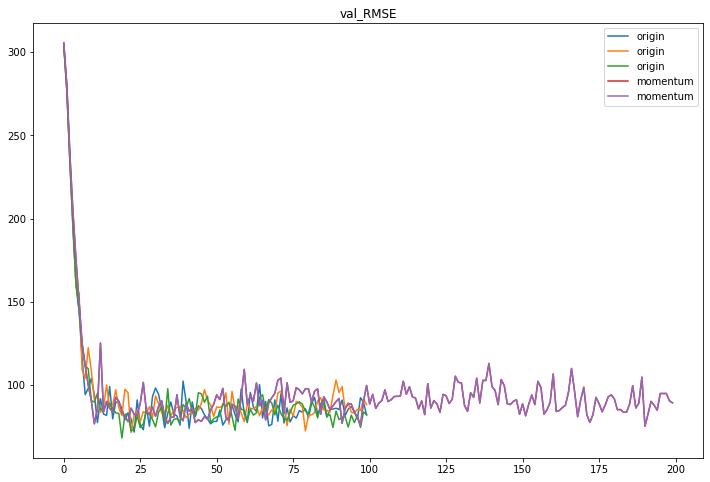

In [105]:
plt.plot(n1_val_RMSE[:100])
plt.plot(n2_val_RMSE[:100])
plt.plot(n3_val_RMSE[:100])

plt.plot(m1_val_RMSE)
plt.plot(m1_val_RMSE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('val_RMSE')
plt.savefig('./figs/val_RMSE.png')



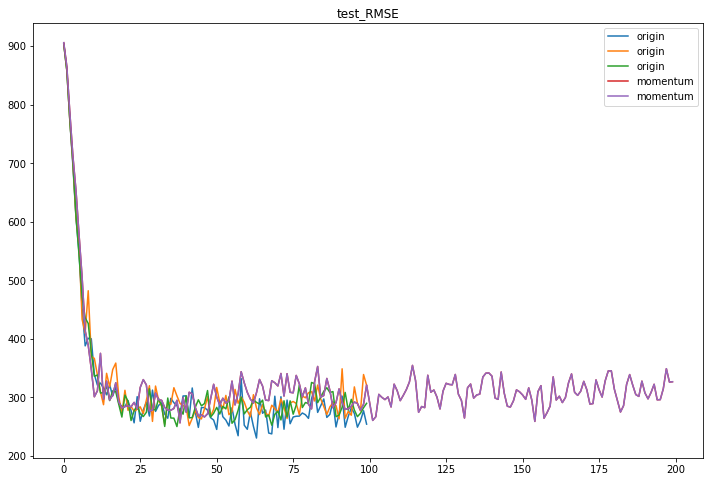

In [107]:
plt.plot(n1_test_RMSE[:100])
plt.plot(n2_test_RMSE[:100])
plt.plot(n3_test_RMSE[:100])

plt.plot(m1_test_RMSE)
plt.plot(m1_test_RMSE)
plt.legend(['origin','origin','origin','momentum','momentum',])
plt.title('test_RMSE')
plt.savefig('./figs/test_RMSE.png')



In [ ]:

with open(osp.join('logs',log_file),'r') as f:
    logs = f.read()
    logs = logs.split('\n')
    logs = logs[5:]
    logs.remove('Best Val!')
    print(len(logs))

In [96]:

train_loss = np.zeros(200)
train_MAPE = np.zeros(200)
test_MAPE = np.zeros(200)
val_MAPE = np.zeros(200)
train_RMSE = np.zeros(200)
test_RMSE = np.zeros(200)
val_RMSE = np.zeros(200)
trains = []
for iter_log in logs:
    if re.match('Epoch [0-9]* \[Test seq \(cond on sampled tp\)\] \| MAPE', iter_log):
        test_MAPE[int(iter_log[6:10])-1] = float(iter_log[50:58])
        test_RMSE[int(iter_log[6:10])-1] = float(iter_log[66:-2])
    elif re.match('Epoch [0-9]* \[Val seq \(cond on sampled tp\)\] \|  MAPE', iter_log):
        val_MAPE[int(iter_log[6:10])-1] = float(iter_log[50:58])
        val_RMSE[int(iter_log[6:10])-1] = float(iter_log[66:-2])
        trains.append(iter_log)
    elif re.match('Epoch [0-9]* \[Train seq \(cond on sampled tp\)\] \| Loss', iter_log):
        train_loss[int(iter_log[6:10])-1] = float(iter_log[51:65])
        train_MAPE[int(iter_log[6:10])-1] = float(iter_log[73:81])
        train_RMSE[int(iter_log[6:10])-1] = float(iter_log[89:99])
        # trains.append(iter_log)


200

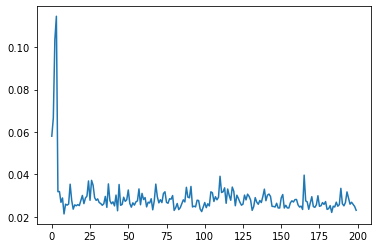

In [84]:
plt.plot(val_MAPE)